In [505]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import os

import plotly.express as px

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
import networkx as nx
from scipy.spatial import distance
from sklearn.cluster import KMeans

import warnings

pd.options.mode.chained_assignment = None  # Suppresses chained assignment warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Data processing

## Utils function

In [333]:
def extractDf(dfPlotTrajectory, obstacle, view, haptics):
    dfplot = dfPlotTrajectory.query(f"Obs == '{obstacle}' & View == '{view}' & Haptics == '{haptics}'")[[ "Time", "meanPosX", "meanPosY", "meanPosZ", "desiredSeparation"]]
    return dfplot

def compute_network_path(kmeans, startClust, endClust):
    """
    Build the network graph from kmeans.cluster_centers_ where:
      - Every cluster (except the start and end) is connected to its two closest clusters.
      - The start and end clusters are each connected to their nearest neighbor.
    
    Then, compute the shortest path (by Euclidean distance) from the start cluster to the end cluster.
    
    Parameters:
        kmeans   : The fitted k-means object with attribute cluster_centers_ (numpy array of shape (n_clusters, 2)).
        startClust : Numpy array [x, y] representing the start cluster.
        endClust   : Numpy array [x, y] representing the end cluster.
        
    Returns:
        path_coords : A list of cluster centers (each as [x, y]) representing the ordered path from start to end.
    """
    centers = kmeans.cluster_centers_
    G = nx.Graph()
    
    # Add each cluster center as a node in the graph.
    for i, c in enumerate(centers):
        G.add_node(i, pos=c)
    
    # Identify indices of the start and end clusters.
    start_index = np.where((centers == startClust).all(axis=1))[0][0]
    end_index   = np.where((centers == endClust).all(axis=1))[0][0]
    
    # For each cluster (except start and end), connect to its two closest clusters.
    for i, c in enumerate(centers):
        if i == start_index or i == end_index:
            continue  # Skip the start and end clusters.
        dists = distance.cdist([c], centers)[0]
        sorted_indices = np.argsort(dists)
        # The closest is itself (distance 0), so take the next two.
        for j in sorted_indices[1:3]:
            G.add_edge(i, j, weight=dists[j])
    
    # For the start cluster, add an edge to its nearest neighbor (ignoring itself).
    dists = distance.cdist([startClust], centers)[0]
    sorted_indices = np.argsort(dists)
    neighbor = sorted_indices[1]
    G.add_edge(start_index, neighbor, weight=dists[neighbor])
    
    # For the end cluster, add an edge to its nearest neighbor.
    dists = distance.cdist([endClust], centers)[0]
    sorted_indices = np.argsort(dists)
    neighbor = sorted_indices[1]
    G.add_edge(end_index, neighbor, weight=dists[neighbor])
    
    # Compute the shortest path from the start to end cluster.
    path_indices = nx.shortest_path(G, source=start_index, target=end_index, weight='weight')
    
    # Convert node indices back to coordinates.
    path_coords = [centers[i] for i in path_indices]
    return path_coords

def get_progress(x, y, path):
    """
    Compute a progress index (0 = start, 1 = end) for a given point (x, y) along a path.
    
    The path is assumed to be an ordered list of points (each as [x, y]). The function works by
    projecting the point onto each segment of the path and selecting the projection with the minimum distance.
    Then it calculates the cumulative distance from the start of the path to that projection and normalizes by
    the total path length.
    
    Parameters:
        x, y : Coordinates of the query point.
        path : Ordered list of points (each as [x, y]) defining the path from start to end.
    
    Returns:
        progress : A float between 0 (at the start) and 1 (at the end) indicating the point's relative position along the path.
    """
    P = np.array([x, y])
    
    # Compute cumulative distances along the path.
    cumulative = [0]
    total_length = 0
    for i in range(1, len(path)):
        seg_length = np.linalg.norm(np.array(path[i]) - np.array(path[i-1]))
        total_length += seg_length
        cumulative.append(total_length)
    
    # Project P onto each segment and find the closest projection.
    min_dist = float('inf')
    proj_length = None  # Distance along the path corresponding to the best projection.
    for i in range(1, len(path)):
        A = np.array(path[i-1])
        B = np.array(path[i])
        AB = B - A
        seg_len_sq = np.dot(AB, AB)
        if seg_len_sq == 0:  # Degenerate segment.
            continue
        t = np.dot(P - A, AB) / seg_len_sq
        t_clamped = np.clip(t, 0, 1)
        proj = A + t_clamped * AB  # Projection of P onto segment [A, B]
        d = np.linalg.norm(P - proj)
        if d < min_dist:
            min_dist = d
            seg_length = np.linalg.norm(AB)
            proj_length = cumulative[i-1] + t_clamped * seg_length

    progress = proj_length / total_length
    return progress

def defineProgress(dfPlotTraj, obstacle, view, haptics):

    dfplot = extractDf(dfPlotTraj, obstacle, view, haptics)
    dfplot.dropna(inplace=True)

    kmeans = KMeans(n_clusters=60)
    kmeans.fit(dfplot[["meanPosX", "meanPosZ"]])

    startClust = dfplot.iloc[0][["meanPosX", "meanPosZ"]].values;
    endClust = dfplot.iloc[-1][["meanPosX", "meanPosZ"]].values;

    startClust = kmeans.cluster_centers_[distance.cdist([startClust], kmeans.cluster_centers_).argmin()];
    endClust = kmeans.cluster_centers_[distance.cdist([endClust], kmeans.cluster_centers_).argmin()];


    path = compute_network_path(kmeans, startClust, endClust)

    dfplot["progress"] = dfplot.apply(lambda row: get_progress(row["meanPosX"], row["meanPosZ"], path), axis=1)

    dfplot["progressBin"] = pd.cut(dfplot["progress"], bins=60)
    dfplot["meanPosXReal"] = dfplot["meanPosX"].astype(float)
    dfplot["meanPosYReal"] = dfplot["meanPosZ"].astype(float)

    dfplotFinal = dfplot.groupby("progressBin")[["meanPosXReal", "meanPosYReal"]].mean().reset_index()

    color = dfplot.groupby("progressBin")[["meanPosXReal"]].count().reset_index()
    color["meanPosXReal"] = (color["meanPosXReal"] - color["meanPosXReal"].min()) / (color["meanPosXReal"].nlargest(2).iloc[-1] - color["meanPosXReal"].min())
    color["meanPosXReal"] = color["meanPosXReal"].clip(0, 1)

    #make the color from green to red
    color["color"] = color["meanPosXReal"]

    dfplotFinal = dfplotFinal.merge(color[["progressBin", "color"]], on="progressBin")

    return dfplot, dfplotFinal
    

In [334]:
def violinGraphSituation(df, metric):
    grouped = df.groupby(["View", "Obstacle"])
    
    all_data = []
    positions = []
    x_labels = []
    colors = []
    pos_counter = 1
    scenario_separators = []

    prev_view_obstacle = None
    for (view, obstacle), subset in grouped:
        h_times = subset[subset["Haptics"] == "H"][metric].values
        nh_times = subset[subset["Haptics"] == "NH"][metric].values
        
        h_count = len(h_times)
        nh_count = len(nh_times)
        
        all_data.append(h_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-H\n(n={h_count})")
        colors.append("red")
        pos_counter += 1

        all_data.append(nh_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-NH\n(n={nh_count})")
        colors.append("blue")
        pos_counter += 1

        if prev_view_obstacle is not None and prev_view_obstacle != (view, obstacle):
            scenario_separators.append(pos_counter - 2)  # Adjust separator position
        prev_view_obstacle = (view, obstacle)
    
    plt.figure(figsize=(12, 6))
    violin_parts = plt.violinplot(dataset=all_data, positions=positions, showmeans=True)
    
    for i, pc in enumerate(violin_parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

    for partname in ['cbars', 'cmins', 'cmaxes', 'cmeans']:
        vp = violin_parts[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)
    
    for sep in scenario_separators:
        plt.axvline(x=sep-0.5, color='black', linestyle='--', linewidth=1)
    
    plt.xticks(positions, x_labels, rotation=45, ha='right')
    plt.xlabel("View - Obstacle - Haptics")
    plt.ylabel(metric)
    plt.title(f"Violin Plot of {metric} by View, Obstacle, and Haptics (H=Red, NH=Blue)")
    plt.tight_layout()
    plt.show()

def boxPlotSituation(df, metric):
    grouped = df.groupby(["View", "Obstacle"])
    
    all_data = []
    positions = []
    x_labels = []
    colors = []
    pos_counter = 1
    scenario_separators = []
    
    prev_view_obstacle = None
    for (view, obstacle), subset in grouped:
        h_times = subset[subset["Haptics"] == "H"][metric].values
        nh_times = subset[subset["Haptics"] == "NH"][metric].values
        
        h_count = len(h_times)
        nh_count = len(nh_times)
        
        all_data.append(h_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-H\n(n={h_count})")
        colors.append("red")
        pos_counter += 1
        
        all_data.append(nh_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-NH\n(n={nh_count})")
        colors.append("blue")
        pos_counter += 1
        
        if prev_view_obstacle is not None and prev_view_obstacle != (view, obstacle):
            scenario_separators.append(pos_counter - 2)  # Adjust separator position
        prev_view_obstacle = (view, obstacle)
    
    plt.figure(figsize=(12, 6))
    box_parts = plt.boxplot(all_data, positions=positions, patch_artist=True, showmeans=True)
    
    for i, box in enumerate(box_parts['boxes']):
        box.set_facecolor(colors[i])
        box.set_edgecolor('black')
        box.set_alpha(0.7)
    
    for sep in scenario_separators:
        plt.axvline(x=sep - 0.5, color='black', linestyle='--', linewidth=1)
    
    plt.xticks(positions, x_labels, rotation=45, ha='right')
    plt.xlabel("View - Obstacle - Haptics")
    plt.ylabel(metric)
    plt.title(f"Box Plot of {metric} by View, Obstacle, and Haptics (H=Red, NH=Blue)")
    plt.tight_layout()
    plt.show()


In [498]:

def plot_path_analysis_speed(dfPlot, title):
    fig, axes = plt.subplots(1,5, figsize=(50, 10))
    
    # Scatter plot
    axes[0].plot(dfPlot["meanPosX"], dfPlot["meanPosZ"], 'ro', label="Haptic", markersize=0.5)
    axes[0].legend()
    axes[0].set_title("Scatter Plot")
    
    # Heatmap
    axes[1].hist2d(dfPlot["meanPosX"], dfPlot["meanPosZ"], bins=100)
    axes[1].set_title("Heatmap")
    
    # KMeans Clustering
    kmeans = KMeans(n_clusters=60, n_init=10)
    kmeans.fit(dfPlot[["meanPosX", "meanPosZ"]])
    
    axes[2].hist2d(dfPlot["meanPosX"], dfPlot["meanPosZ"], bins=100)
    axes[2].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red')
    axes[2].set_title("KMeans Clustering")
    
    # Path Visualization
    dfPlot.dropna(inplace=True)

    
    startClust = dfPlot.iloc[0][["meanPosX", "meanPosZ"]].values.astype(float)
    endClust   = dfPlot.iloc[-1][["meanPosX", "meanPosZ"]].values.astype(float)

    print(startClust, "   ", endClust)

    print(distance.cdist([startClust], kmeans.cluster_centers_).argmin())

    startClust = kmeans.cluster_centers_[distance.cdist([startClust], kmeans.cluster_centers_).argmin()];
    endClust = kmeans.cluster_centers_[distance.cdist([endClust], kmeans.cluster_centers_).argmin()];
    
    path = compute_network_path(kmeans, startClust, endClust)


    
    for i in range(len(path) - 1):
        progress = get_progress(path[i][0], path[i][1], path)
        color = (1 - progress, progress, 0)
        axes[3].plot([path[i][0], path[i+1][0]], [path[i][1], path[i+1][1]], 'o-', color=color)
    
    axes[3].plot([startClust[0], endClust[0]], [startClust[1], endClust[1]], 'bo')
    axes[3].set_title("Path with Of Progression")

    axes[3].hist2d(dfPlot["meanPosX"], dfPlot["meanPosZ"], bins=100)


    dfplotFinal = dfPlot.groupby("progressBin")[["meanPosXReal", "meanPosYReal"]].mean().reset_index()


    color = dfPlot.groupby("progressBin")[["meanPosXReal"]].count().reset_index()
    color["meanPosXReal"] = (color["meanPosXReal"] - color["meanPosXReal"].min()) / (color["meanPosXReal"].nlargest(2).iloc[-1] - color["meanPosXReal"].min())
    color["meanPosXReal"] = color["meanPosXReal"].clip(0, 1)

    #make the color from green to red
    color["color"] = color["meanPosXReal"]


    dfplotFinal = dfplotFinal.merge(color[["progressBin", "color"]], on="progressBin")

    # Get the values from your DataFrame
    x = dfplotFinal["meanPosXReal"].values
    y = dfplotFinal["meanPosYReal"].values
    c = dfplotFinal["color"].values  # these should be values between 0 and 1

    # Create line segments from the x,y points.
    # Each segment is defined by two consecutive points.
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Compute an average color for each segment
    seg_colors = (c[:-1] + c[1:]) / 2

    # Create a LineCollection. The cmap 'viridis' will be used,
    # and the norm ensures the colormap spans from 0 to 1.
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['green', 'red'])

    # Number of interpolation steps per segment (higher = smoother gradient)
    num_interp = 10  

    # Create interpolated segments and colors
    new_segments = []
    new_colors = []

    for i in range(len(x) - 1):
        # Linearly interpolate points along the segment
        interp_x = np.linspace(x[i], x[i+1], num_interp)
        interp_y = np.linspace(y[i], y[i+1], num_interp)
        
        # Linearly interpolate colors for smooth transition
        interp_c = np.linspace(c[i], c[i+1], num_interp)

        # Create the sub-segments
        for j in range(num_interp - 1):
            new_segments.append([[interp_x[j], interp_y[j]], [interp_x[j+1], interp_y[j+1]]])
            new_colors.append(interp_c[j])  # Assign color gradually along the segment

    # Convert to NumPy array for `LineCollection`
    new_segments = np.array(new_segments)

    # Create the LineCollection with the interpolated color map
    lc = LineCollection(new_segments, cmap=custom_cmap, norm=plt.Normalize(0, 1))
    lc.set_array(np.array(new_colors))
    lc.set_linewidth(2)

    # Plotting the gradient line
    axes[4].add_collection(lc)
    plt.colorbar(lc, ax=axes[4], label="Gradient Value")

    # Also plot the Haptic points
    axes[4].plot(dfPlot["meanPosX"], dfPlot["meanPosZ"], 'o', markersize=0.5, alpha=0.05, color='blue')

    axes[4].set_title("Gradient Line for speed")

    #STE THE main title

    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()


def showPlot(index, dfTrajectory):
    title = f"Path Progression for {dfTrajectory.iloc[index]["Obstacle"]} - {dfTrajectory.iloc[index]["View"]} - {dfTrajectory.iloc[index]["Haptics"]}"
    plot_path_analysis_speed(dfTrajectory.iloc[index]["FlightState"], title)


def plot_path_analysis_spread(dfPlot, title):
    fig, axes = plt.subplots(1,1, figsize=(10, 10))

    dfplotFinal = dfPlot.groupby("progressBin")[["meanPosXReal", "meanPosYReal", "desiredSeparation"]].mean().reset_index()


    color = dfPlot.groupby("progressBin")[["desiredSeparation"]].mean().reset_index()
   # color["meanPosXReal"] = (color["desiredSeparation"] - color["desiredSeparation"].min()) / (color["desiredSeparation"].max() - color["desiredSeparation"].min())
    color["meanPosXReal"] = color["desiredSeparation"]
    #color["meanPosXReal"] = color["meanPosXReal"].clip(0, 1)

    #make the color from green to red
    color["color"] = color["meanPosXReal"]


    dfplotFinal = dfplotFinal.merge(color[["progressBin", "color"]], on="progressBin")

    # Get the values from your DataFrame
    x = dfplotFinal["meanPosXReal"].values
    y = dfplotFinal["meanPosYReal"].values
    c = dfplotFinal["color"].values  # these should be values between 0 and 1

    # Create line segments from the x,y points.
    # Each segment is defined by two consecutive points.
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    # Create a LineCollection. The cmap 'viridis' will be used,
    # and the norm ensures the colormap spans from 0 to 1.
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['green', 'red'])

    # Number of interpolation steps per segment (higher = smoother gradient)
    num_interp = 10  

    # Create interpolated segments and colors
    new_segments = []
    new_colors = []

    for i in range(len(x) - 1):
        # Linearly interpolate points along the segment
        interp_x = np.linspace(x[i], x[i+1], num_interp)
        interp_y = np.linspace(y[i], y[i+1], num_interp)
        
        # Linearly interpolate colors for smooth transition
        interp_c = np.linspace(c[i], c[i+1], num_interp)

        # Create the sub-segments
        for j in range(num_interp - 1):
            new_segments.append([[interp_x[j], interp_y[j]], [interp_x[j+1], interp_y[j+1]]])
            new_colors.append(interp_c[j])  # Assign color gradually along the segment

    # Convert to NumPy array for `LineCollection`
    new_segments = np.array(new_segments)

    # Create the LineCollection with the interpolated color map
    lc = LineCollection(new_segments, cmap=custom_cmap, norm=plt.Normalize(0, 5))
    lc.set_array(np.array(new_colors))
    lc.set_linewidth(2)

    # Plotting the gradient line
    axes.add_collection(lc)
    
    plt.colorbar(lc, ax=axes, label="Spreadness")

    # Also plot the Haptic points
    axes.plot(dfPlot["meanPosX"], dfPlot["meanPosZ"], 'o', markersize=0.5, alpha=0.05, color='blue')

    axes.set_title("Gradient Line for speed")

    #STE THE main title

    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

def showPlot_spread(index, dfTrajectory):
    title = f"Path Progression for {dfTrajectory.iloc[index]["Obstacle"]} - {dfTrajectory.iloc[index]["View"]} - {dfTrajectory.iloc[index]["Haptics"]}"
    plot_path_analysis_spread(dfTrajectory.iloc[index]["FlightState"], title)

In [503]:
def getCrash(df):
    crash = df.groupby("droneId").count()[["Time"]].reset_index()
    maxCrash = crash["Time"].max()

    droneCrash = crash[crash["Time"] != maxCrash][["droneId", "Time"]].values

    dfCrash = pd.DataFrame(columns=["droneId", "Time"])

    for drone in droneCrash:
        timeCrash = df[df["droneId"] == drone[0]]["Time"].max()
        dfCrash.loc[len(dfCrash)] = [drone[0], timeCrash]
        
    return dfCrash

def analyseFile(folderPath, file):
    separators = file.split('_')
    run = 0
    obstacle = ''
    view = ''
    haptics = ''
    order = ''

    if len(separators) == 4:
        run = 1
    elif len(separators) == 5:
        run = 2
    else:
        raise Exception("This is not a valid file")

    if "Obs" in separators[0]:
        obstacle = "Obstacle"
    elif "Collectibles" in separators[0]:
        obstacle = "Collectibles"
    else:
        raise Exception("This is not a valid file")
    
    if "TDV" in separators[0]:
        view = "TDV"
    elif "FPV" in separators[0]:
        view = "FPV"
    else:
        raise Exception("This is not a valid file")
    
    if "NH" in separators[-3]:
        haptics = "NH"
    elif "H" in separators[-3]:
        haptics = "H"
    else:
        raise Exception("This is not a valid file")
    
    if "NO" in separators[-2]:
        order = "NO"
    elif "O" in separators[-2]:
        order = "O"
    else:
        raise Exception("This is not a valid file")
    
    date = separators[-1][:-5]

    file = os.path.join(folderPath, file)

    PID = folderPath.split('\\')[-1]

   # data = pd.read_json(file)
    
    #make a dataframe of the data
    di = {"PID":PID, "Run" : run, "Obstacle" : obstacle, "View" : view, "Haptics" : haptics, "Order" : order, "Date" : date, "File" : file}

    return di

def makeFromFolder(folderPath):
    files = os.listdir(folderPath)
    files = [f for f in files if f.endswith('.json')]
    foreachFile = [analyseFile(folderPath, f) for f in files]
    return foreachFile

def makeFromFolders(folders):
    foreachFolder = [makeFromFolder(f) for f in folders]
    print(foreachFolder)
    return foreachFolder

def analyseSwarmState(data, time): ### ake data["swarmState"]
    rows = []

    for drone_entry in data:
        drone_entry.keys()
        drone_id = int(drone_entry["droneId"])
        drone_state = drone_entry["droneState"]

#['position', 'velocity', 'FobstacleAvoidance', 'FolfatiSaber', 'Falignment', 'network', 'layer', 'crashedPred']
        positions = drone_state.get("position", [])
        velocities = drone_state.get("velocity", [])
        obstacles = drone_state.get("FobstacleAvoidance", [])
        allignement = drone_state.get("Falignment", [])
        olfati = drone_state.get("FolfatiSaber", [])
        # embodied_list = drone_state.get("embodied", [])
        # selected_list = drone_state.get("selected", [])
        network_list = drone_state.get("network", [])
        layer_list = drone_state.get("layer", [])
        crashedPred_list = drone_state.get("crashedPred", [])

        # Determine how many time steps exist for this drone
        number_of_time_steps = max(
            len(positions),
            len(velocities),
            len(network_list),
            len(obstacles),
            len(olfati),
            len(allignement)
        )

        for i in range(number_of_time_steps):
            # Fetch the position dictionary if it exists, otherwise {}
            if i < len(positions) and isinstance(positions[i], dict):
                pos = positions[i]
                posX = pos.get("x", None)
                posY = pos.get("y", None)
                posZ = pos.get("z", None)
            else:
                posX, posY, posZ = None, None, None

            # Fetch the velocity dictionary if it exists, otherwise {}
            if i < len(velocities) and isinstance(velocities[i], dict):
                vel = velocities[i]
                velX = vel.get("x", None)
                velY = vel.get("y", None)
                velZ = vel.get("z", None)
            else:
                velX, velY, velZ = None, None, None

            if i < len(obstacles) and isinstance(obstacles[i], dict):
                obs = obstacles[i]
                obsX = obs.get("x", None)
                obsY = obs.get("y", None)
                obsZ = obs.get("z", None)

            if i < len(olfati) and isinstance(olfati[i], dict):
                olf = olfati[i]
                olfX = olf.get("x", None)
                olfY = olf.get("y", None)
                olfZ = olf.get("z", None)

            if i < len(allignement) and isinstance(allignement[i], dict):
                all = allignement[i]
                allX = all.get("x", None)
                allY = all.get("y", None)
                allZ = all.get("z", None)

            net = network_list[i] if i < len(network_list) else None
            layer = layer_list[i] if i < len(layer_list) else None
            crashedPred = crashedPred_list[i] if i < len(crashedPred_list) else None

            row_data = {
                "droneId": drone_id,
                "Time": time[i],
                "posX": posX,
                "posY": posY,
                "posZ": posZ,
                "velX": velX,
                "velY": velY,
                "velZ": velZ,
                "obsX": obsX,
                "obsY": obsY,
                "obsZ": obsZ,
                "olfX": olfX,
                "olfY": olfY,
                "olfZ": olfZ,
                "allX": allX,
                "allY": allY,
                "allZ": allZ,
                "network": net,
                "layer": layer,
                "crashedPred": crashedPred
                
            }

            rows.append(row_data)



    df = pd.DataFrame(rows)

    return df

def getInfo(df):

    with open(df["File"], "r") as f: 
        data = json.load(f)

    rows = []

    # Read top-level constants (if you want them in every row)
    max_speed = data.get("maxSpeed", None)
    max_force = data.get("maxForce", None)
    neighbor_radius = data.get("neighborRadius", None)
    maxSpeed = data.get("maxSpeed", None)
    maxForce = data.get("maxForce", None)
    alpha = data.get("alpha", None)
    beta = data.get("beta", None)
    delta = data.get("delta", None)
    cvm = data.get("cvm", None)
    avoidance_radius = data.get("avoidanceRadius", None)
    desiredSeparationToObs = data.get("desiredSeparationToObs", None)
    avoidance_force = data.get("avoidanceForce", None)
    drone_radius = data.get("droneRadius", None)
    damping_factor = data.get("dampingFactor", None)

    constants = {"max_speed": max_speed, "max_force": max_force, "neighbor_radius": neighbor_radius, "maxSpeed": maxSpeed, "maxForce": maxForce, "alpha": alpha, "beta": beta, "delta": delta, "cvm": cvm, "avoidance_radius": avoidance_radius, "desiredSeparationToObs": desiredSeparationToObs, "avoidance_force": avoidance_force, "drone_radius": drone_radius, "damping_factor": damping_factor}

    cameraForward = data.get("cameraForward", None)
    subNetworkNumber = data.get("subNetworkNumber", None)
    idLeader = data.get("idLeader", None)
    isolation = data.get("isolation", None)
    swarmConnectivness = data.get("swarmConnectivness", None)
    time = data.get("time", None)
    alignment = data.get("alignment", None)
    desiredSeparation = data.get("desiredSeparation", None)
    #make a df of the data

    dic = {"Time": time, "cameraForward": cameraForward, "subNetworkNumber": subNetworkNumber, "idLeader": idLeader, "isolation": isolation, "swarmConnectivness": swarmConnectivness, "alignment": alignment, "desiredSeparation": desiredSeparation}
    dfStudy = pd.DataFrame(dic) 



    swarmState = data.get("swarmState", None)
    dfSwarmState = cleanData(analyseSwarmState(swarmState, time))

    stars = data.get("stars", None)
    dfStars = pd.DataFrame(stars)

    dfCrashed = getCrash(dfSwarmState)
    #
    return cleanData(dfStudy), dfStars, constants, dfSwarmState, dfCrashed

def cleanData(df):
    #remove the rows where time  <= 0
    df = df[df["Time"] > 0]
    #remove the rows where time is not a number

    return df


In [504]:
def processAdditionalInfo(dfFolders):
    for index , _ in dfFolders.iterrows():
        print(index, sep=' ', end=' ', flush=True)
        dfFolders.at[index, "Crash"] = pd.DataFrame(columns=["droneId", "Time"])
        dfFolders.at[index, "Study"] = pd.DataFrame(columns=["Time", "cameraForward", "subNetworkNumber", "idLeader", "isolation", "swarmConnectivness", "alignment", "desiredSeparation"])
        dfFolders.at[index, "Stars"] = pd.DataFrame(columns=["droneId", "starId", "starType", "starPosition", "starRadius", "starColor", "starIntensity", "starDirection", "starAngle", "starDistance", "starSpeed", "starTime"])
        dfFolders.at[index, "SwarmState"] = pd.DataFrame(columns=["droneId", "Time", "posX", "posY", "posZ", "velX", "velY", "velZ", "obsX", "obsY", "obsZ", "olfX", "olfY", "olfZ", "allX", "allY", "allZ", "network", "layer", "crashedPred"])
        
        dfStudy, dfStars, constants, dfSwarmState, dfCrash = getInfo(dfFolders.loc[index])

        #SETUP
        dfFolders.at[index, "Crash"] = dfCrash
        dfFolders.at[index, "Study"] = dfStudy
        dfFolders.at[index, "Stars"] = dfStars
        dfFolders.at[index, "SwarmState"] = dfSwarmState

        #PLOT METRICS
        dfFolders.at[index, "Constants"] = pd.DataFrame(constants, index=[0])
        dfFolders.at[index, "FinalTime"] = dfStudy["Time"].max()
        dfFolders.at[index, "NumberOfCrash"] = len(dfCrash)

        #ISOLATION TIME
        isolation_time = 1 - dfFolders.at[index, "Study"]["isolation"].value_counts().loc[0] / len(dfFolders.at[index, "Study"])
        dfFolders.at[index, "isolationTime"] = isolation_time

        #TRAJECTORY
        dfFolders.at[index, "Study"]["meanPosX"] = np.nan
        dfFolders.at[index, "Study"]["meanPosY"] = np.nan
        dfFolders.at[index, "Study"]["meanPosZ"] = np.nan
        mean_values = dfFolders.at[index, "SwarmState"].groupby("Time")[["posX", "posY", "posZ"]].mean().reset_index()
        dfFolders.at[index, "Study"]["meanPosX"][:-1] = mean_values["posX"].values;
        dfFolders.at[index, "Study"]["meanPosY"][:-1] = mean_values["posY"].values;
        dfFolders.at[index, "Study"]["meanPosZ"][:-1] = mean_values["posZ"].values;

        ## STAR 
        idLeader = []
        postionLeader = []
        for i in range(len(dfFolders.at[index, "Stars"])):
            time = dfFolders.at[index, "Stars"].iloc[i]["timeCollected"]
            indexTime = dfFolders.at[index, "Study"].apply(lambda row: np.abs(time - row["Time"]), axis=1).argmin()
            idLeader.append(dfFolders.at[index, "Study"].iloc[indexTime]["idLeader"])

            timeRecorded = dfFolders.at[index, "Study"].iloc[indexTime]["Time"]
            pos = dfFolders.at[index, "SwarmState"].query(f"Time == {timeRecorded} & droneId == {dfFolders.at[index, "Study"].iloc[indexTime]["idLeader"]}")[["posX", "posY", "posZ"]].values;
            if len(pos) == 0:
                postionLeader.append([np.nan, np.nan, np.nan])
            elif len(pos) == 1:
                postionLeader.append(pos[0])
            else:
                print("ERROR")
                postionLeader.append(pos[0])

        if(len(dfFolders.at[index, "Stars"]) > 0):
            dfFolders.at[index, "Stars"]["idLeader"] = idLeader
            dfFolders.at[index, "Stars"]["postionLeader"] = postionLeader
            dfFolders.at[index, "Stars"]["isLeader"] = dfFolders.at[index, "Stars"].apply(lambda row: row["droneId"] == row["idLeader"], axis=1)
            dfFolders.at[index, "leaderPercentage"] = float(dfFolders.at[index, "Stars"]["isLeader"].sum() / len(dfFolders.at[index, "Stars"]))
        else:
            dfFolders.at[index, "leaderPercentage"] = 0

        
        if(len(dfFolders.at[index, "Stars"]) > 0):
            dfFolders.at[index, "Stars"]["positionArray"] = dfFolders.at[index, "Stars"]["position"].apply(lambda row: [row["x"], row["y"], row["z"]])
            dfFolders.at[index, "Stars"]["diffPosition"] = dfFolders.at[index, "Stars"].apply(lambda row: np.linalg.norm(np.array(row["positionArray"]) - np.array(row["postionLeader"])), axis=1)
            dfFolders.at[index, "meanDiffPosition"] = dfFolders.at[index, "Stars"]["diffPosition"].mean()
        else:
            dfFolders.at[index, "meanDiffPosition"] = 0


def groupedConditions(dfFolders):
    dfConditions = pd.DataFrame(columns=["Obstacle", "View", "Haptics", "FlightState"])
    dfPlotTrajectory = pd.DataFrame(columns=["Time", "meanPosX", "meanPosY", "meanPosZ", "Obs", "View", "Haptics", "desiredSeparation"])

    for _, df in dfFolders.iterrows():
        dfAdded = df["Study"][["Time", "meanPosX", "meanPosY", "meanPosZ", "desiredSeparation"]]
        dfAdded["Obs"] = df["Obstacle"]
        dfAdded["View"] = df["View"]
        dfAdded["Haptics"] = df["Haptics"]

        dfPlotTrajectory = pd.concat([dfPlotTrajectory, dfAdded])

    conditions = [["Obstacle", "TDV", "H"], ["Obstacle", "TDV", "NH"], ["Obstacle", "FPV", "H"], ["Obstacle", "FPV", "NH"], ["Collectibles", "TDV", "H"], ["Collectibles", "TDV", "NH"], ["Collectibles", "FPV", "H"], ["Collectibles", "FPV", "NH"]]
    
    for i, condition in enumerate(conditions):
        print(condition)
        dfPlot, _ = defineProgress(dfPlotTrajectory, condition[0], condition[1], condition[2])

        dfConditions.at[i, "Obstacle"] = condition[0]
        dfConditions.at[i, "View"] = condition[1]
        dfConditions.at[i, "Haptics"] = condition[2]
        dfConditions.at[i, "FlightState"] = dfPlot

    return dfConditions, dfPlotTrajectory

## Data processing

In [ ]:
RELATIVEPATH = ".\\Assets\\Data\\"
loadedData = []

for root, dirs, files in os.walk(RELATIVEPATH):
    for name in dirs:

        try:
            int(name)
        except:
            continue

        loadedData.append(os.path.join(root, name))


In [502]:
dfFolders = makeFromFolders(loadedData)
dfFolders = pd.DataFrame([item for sublist in dfFolders for item in sublist])

[[{'PID': '1436', 'Run': 2, 'Obstacle': 'Collectibles', 'View': 'FPV', 'Haptics': 'NH', 'Order': 'O', 'Date': '', 'File': '.\\Assets\\Data\\1436\\FPVCollectibles_1_NH_O_.json'}, {'PID': '1436', 'Run': 1, 'Obstacle': 'Collectibles', 'View': 'FPV', 'Haptics': 'NH', 'Order': 'O', 'Date': '', 'File': '.\\Assets\\Data\\1436\\FPVCollectibles_NH_O_.json'}, {'PID': '1436', 'Run': 2, 'Obstacle': 'Obstacle', 'View': 'FPV', 'Haptics': 'NH', 'Order': 'O', 'Date': '', 'File': '.\\Assets\\Data\\1436\\FPVObs_1_NH_O_.json'}, {'PID': '1436', 'Run': 1, 'Obstacle': 'Obstacle', 'View': 'FPV', 'Haptics': 'NH', 'Order': 'O', 'Date': '', 'File': '.\\Assets\\Data\\1436\\FPVObs_NH_O_.json'}, {'PID': '1436', 'Run': 2, 'Obstacle': 'Collectibles', 'View': 'TDV', 'Haptics': 'NH', 'Order': 'O', 'Date': '', 'File': '.\\Assets\\Data\\1436\\TDVCollectibles_1_NH_O_.json'}, {'PID': '1436', 'Run': 1, 'Obstacle': 'Collectibles', 'View': 'TDV', 'Haptics': 'NH', 'Order': 'O', 'Date': '', 'File': '.\\Assets\\Data\\1436\\TDVC

In [457]:
processAdditionalInfo(dfFolders)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

In [485]:
dfConditions, dfPlotTrajectory = groupedConditions(dfFolders)

['Obstacle', 'TDV', 'H']
7472
['Obstacle', 'TDV', 'NH']
12510
['Obstacle', 'FPV', 'H']
8264
['Obstacle', 'FPV', 'NH']
13926
['Collectibles', 'TDV', 'H']
11300
['Collectibles', 'TDV', 'NH']
17861
['Collectibles', 'FPV', 'H']
14948
['Collectibles', 'FPV', 'NH']
23531


In [ ]:
dfFolders.to_pickle("dfFoldersFinal2.pkl")

# Data anylsis

In [506]:

dfFolders = pd.read_pickle("dfFoldersFinal2.pkl")
   

In [507]:
dfFolders.sample(2)

,PID,Run,Obstacle,View,Haptics,Order,Date,File,Crash,Study,Stars,SwarmState,Constants,FinalTime,NumberOfCrash,isolationTime,leaderPercentage,meanDiffPosition
2,1436,2,Obstacle,FPV,NH,O,,.\Assets\Data\1436\FPVObs_1_NH_O_.json,droneId Time 0 0.0 22.649,Time ...,Empty DataFrame Columns: [] Index: [],droneId Time posX posY...,max_speed max_force neighbor_radius maxSp...,77.231293,1.0,0.0,0.0,0.0
10,179,2,Obstacle,FPV,NH,O,,.\Assets\Data\179\FPVObs_1_NH_O_.json,droneId Time 0 0.0 32.692028 1 ...,Time ...,Empty DataFrame Columns: [] Index: [],droneId Time posX posY...,max_speed max_force neighbor_radius maxSp...,80.121849,2.0,0.0,0.0,0.0


<>:2: SyntaxWarning:

invalid escape sequence '\D'

<>:2: SyntaxWarning:

invalid escape sequence '\D'

C:\Users\Pablo\AppData\Local\Temp\ipykernel_25076\1275316775.py:2: SyntaxWarning:

invalid escape sequence '\D'



In [ ]:
def setQuestionnaire(dfFolders, dfQuestionnaire):
    #read csv file
    questionnaire = pd.read_csv("Assets\Data\questionnaire.csv")

    # find index PID in questionnaire.columns
    indexPID = questionnaire.columns.get_loc("PID")
    indexQ1 = questionnaire.columns.get_loc("Q1_1")

    #make list going from indexPID to indexQ1
    columns = list(range( indexQ1, indexPID+1))
    #Keep first row and then from 3 to the last row
    rows = list(range(2, len(questionnaire)))

    dfQuestionnaire = questionnaire.iloc[rows, columns]
    # Go row by row in your questionnaire DataFrame
    for indexQuestionnaire in range(0, len(dfQuestionnaire)):
        
        dfQ = dfQuestionnaire.iloc[indexQuestionnaire]
        PID = dfQ["PID"]
        
        # Ensure PID is in dfFolders
        if PID not in dfFolders["PID"].values:
            print("PID not found for", PID)
            continue
        
        print(indexQuestionnaire, ":", PID)

        # Check Order from the matching row in dfFolders
        dfFolderQuestionnaire = dfFolders[dfFolders["PID"] == PID].iloc[0]
        Order = (dfFolderQuestionnaire["Order"] == 'O')
        
        # Decide question order based on 'Order'
        if Order:
            questionOrder = ["TDV", "FPV"]
        else:
            questionOrder = ["FPV", "TDV"]


        indexVal = 0 
        for obstacle_type in ["Obstacle", "Collectibles"]:
            for view_type in questionOrder:
                for k in range(6):
                    # Read value from the appropriate column of dfQ
                    value = dfQ[dfQuestionnaire.columns[indexVal]]
                    
                    modIndex = indexVal % 6
                    if modIndex == 0:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "MentalyDemanding"
                        ] = value
                    elif modIndex == 1:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "PhysicalDemanding"
                        ] = value
                    elif modIndex == 2:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "Hurry"
                        ] = value
                    elif modIndex == 3:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "Effort"
                        ] = value
                    elif modIndex == 4:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "Frustration"
                        ] = value
                    elif modIndex == 5:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "Success"
                        ] = value
                    else:
                        print("ERROR with modIndex =", modIndex)

                    indexVal += 1

    
    #find the col index of Q14_1
    indexQ14 = dfQuestionnaire.columns.get_loc("Q14_1")
    #Split the columns from Q14_1 to the end
    columns = list(range(indexQ14, len(dfQuestionnaire.columns)))
    dfQuestionnaireRest = dfQuestionnaire.iloc[:, columns]
    
    colName = []
    for hapticFB in ["ObstacleAvoidance", "Spreadness", "Connectivness", "Disconnection", "TrajPred", "Crash"]:
        for dimension in ["Usefulness", "Annoyance", "Intuitivness", "Precission"]:
            colName.append(f"{hapticFB}_{dimension}")

    colName.append("Comments_Haptics")
    colName.append("TDVvsFPV")
    colName.append("TDVvsFPV_Comments")

    #add the rest of the columns as same as the dfQuestionnaireRest
    
    restOfColumns = dfQuestionnaire.columns[indexQ14+len(colName):]
    tempColName = colName + list(restOfColumns)
    dfQuestionnaireRest.columns = tempColName


    indexQ32 = dfQuestionnaireRest.columns.get_loc("TDVvsFPV_Comments")
    indexQ8 = dfQuestionnaireRest.columns.get_loc("Q8")
    #remove the columns from Q32 to Q8
    columns = list(range(0, indexQ32))
    columns = columns + list(range(indexQ8-1, len(dfQuestionnaireRest.columns)))
    dfQuestionnaireRest = dfQuestionnaireRest.iloc[:, columns]

    colName.append("Gender")
    colName.append("Age")
    colName.append("PlayVideoGames")
    colName.append("PlayVideoGamesWeekly")
    colName.append("PlayVideoGamesWeeklyHighest")
    colName.append("ControlOperated")
    colName.append("ControlOperatedHours")
    colName.append("PID")

    print(len(colName), len(dfQuestionnaireRest.columns))

    dfQuestionnaireRest.columns = colName

    allHaptics = []
    for indexQuestionnaire in range(0, len(dfQuestionnaire)):
        
        dfQ = dfQuestionnaire.iloc[indexQuestionnaire]
        PID = dfQ["PID"]
        
        # Ensure PID is in dfFolders
        if PID not in dfFolders["PID"].values:
            print("PID not found for", PID)
            allHaptics.append(np.nan)
            continue
        
        haptics = dfFolders[dfFolders["PID"] == PID].iloc[0]["Haptics"]
        allHaptics.append(haptics)

    dfQuestionnaireRest["Haptics"] = allHaptics
        
    return dfQuestionnaireRest


dfQuestionnaireRest = setQuestionnaire(dfFolders, dfQuestionnaire)

0 : 1436
1 : 179
PID not found for 4509
3 : 7160
4 : 3201
5 : 709
35 35
PID not found for 4509


In [637]:
dfQuestionnaireRest.sample(2)

,ObstacleAvoidance_Usefulness,ObstacleAvoidance_Annoyance,ObstacleAvoidance_Intuitivness,ObstacleAvoidance_Precission,Spreadness_Usefulness,Spreadness_Annoyance,Spreadness_Intuitivness,Spreadness_Precission,Connectivness_Usefulness,Connectivness_Annoyance,...,TDVvsFPV_Comments,Gender,Age,PlayVideoGames,PlayVideoGamesWeekly,PlayVideoGamesWeeklyHighest,ControlOperated,ControlOperatedHours,PID,Haptics
3,50,50,50,50,80,70,60,20,0,100,...,NaN,Male,23,"Yes, but not anymore",NaN,‭2-4 hours,"Yes, but not anymore",20 hours or fewer,179,NH
7,50,50,50,50,30,80,20,0,20,70,...,NaN,Male,22,"Yes, but not anymore",NaN,‭2-4 hours,No,I have not used remote-controlled vehicles,709,NH


## Main observation

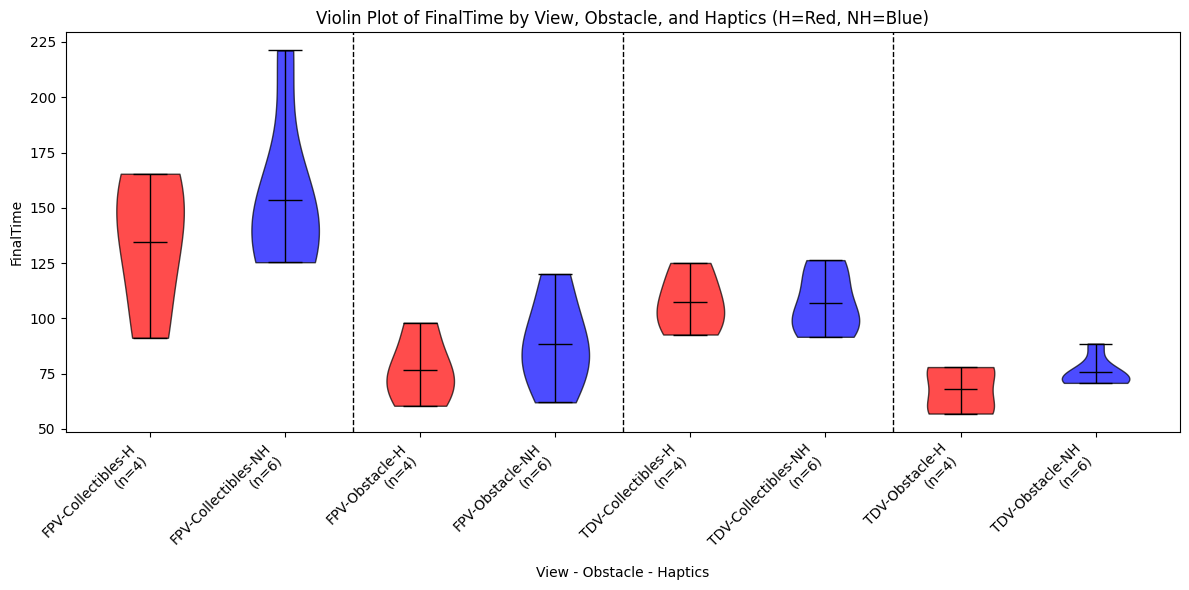

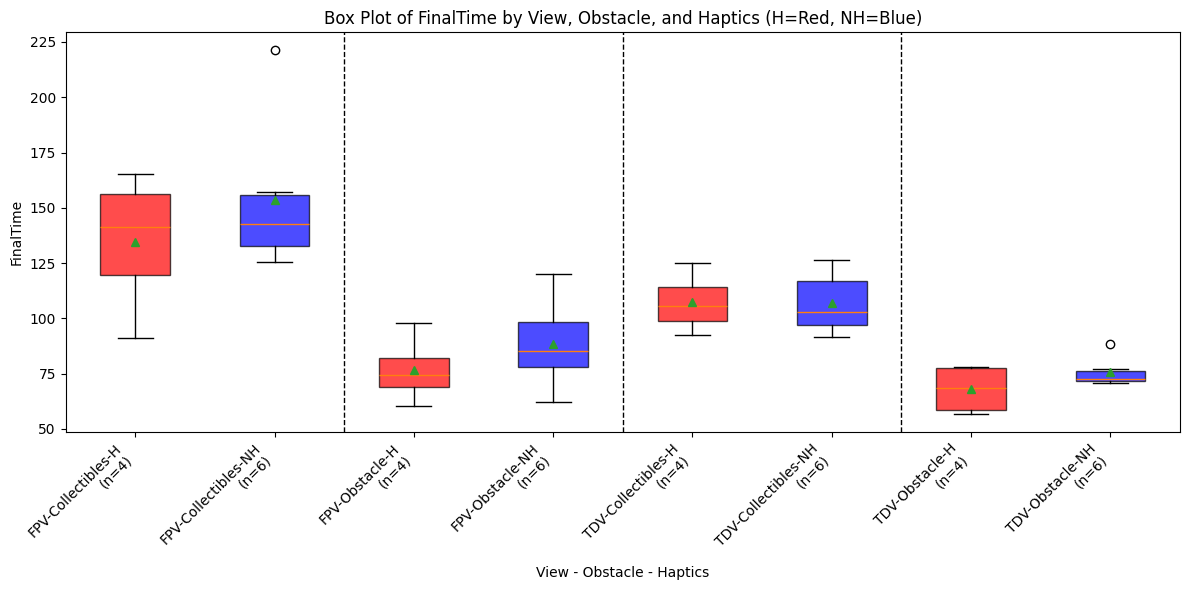

In [473]:
violinGraphSituation(dfFolders, "FinalTime")
boxPlotSituation(dfFolders, "FinalTime")

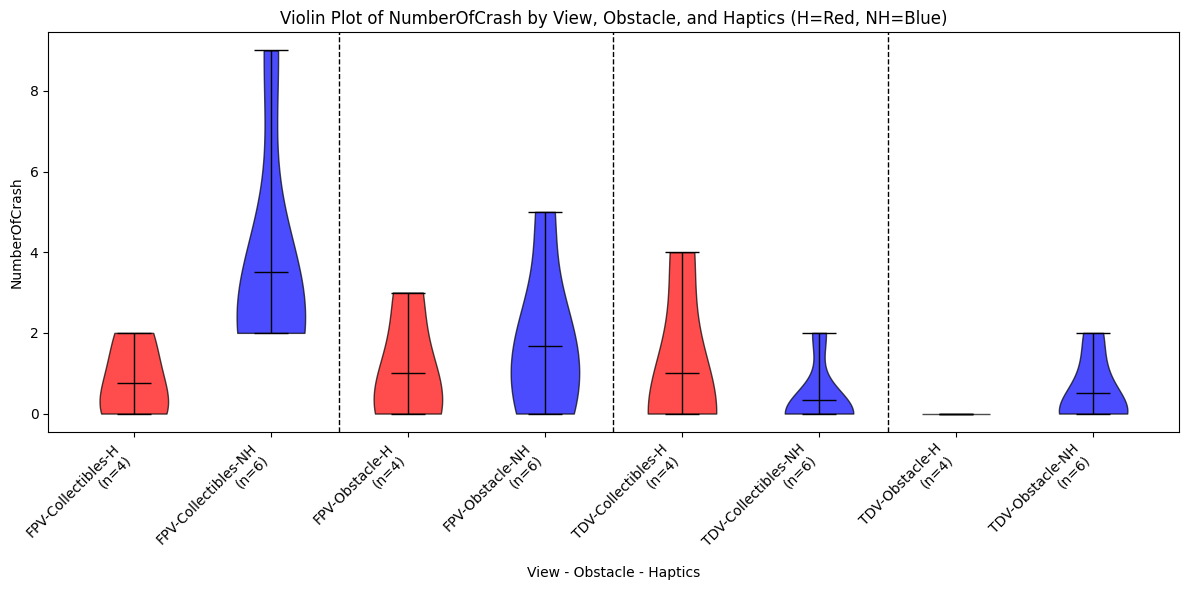

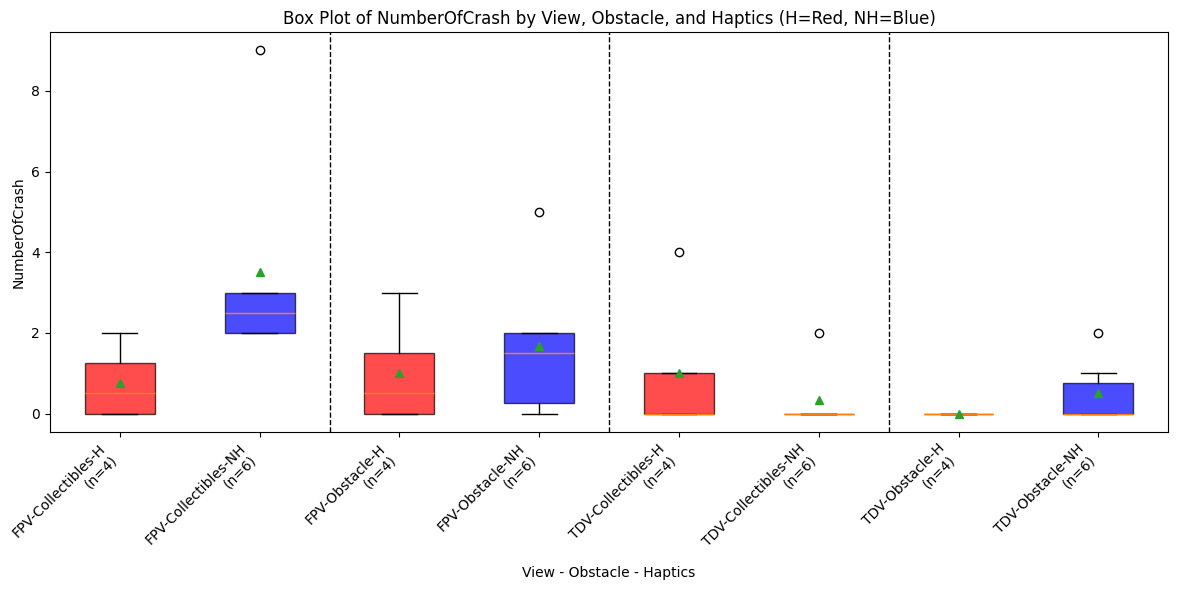

In [474]:
violinGraphSituation(dfFolders, "NumberOfCrash")
boxPlotSituation(dfFolders, "NumberOfCrash")

In [321]:
# df = dfFolders.iloc[0]["SwarmState"]

# fig = px.scatter_3d(
#     df,
#     x='posX',        # x-axis
#     y='posZ',        # y-axis (floor plane)
#     z='posY',        # z-axis (height)
#     color='droneId', # different colors for each drone
#     title="3D Trajectory Plot for All Drones",
#     #scale the max and min values to make the plot look better
#     range_x=[-50, 150],
#     range_y=[-50, 150],
#     range_z=[-50, 100]
# )

# # Adjust marker size or opacity as desired
# fig.update_traces(marker=dict(size=3, opacity=0.8))

# fig.show()

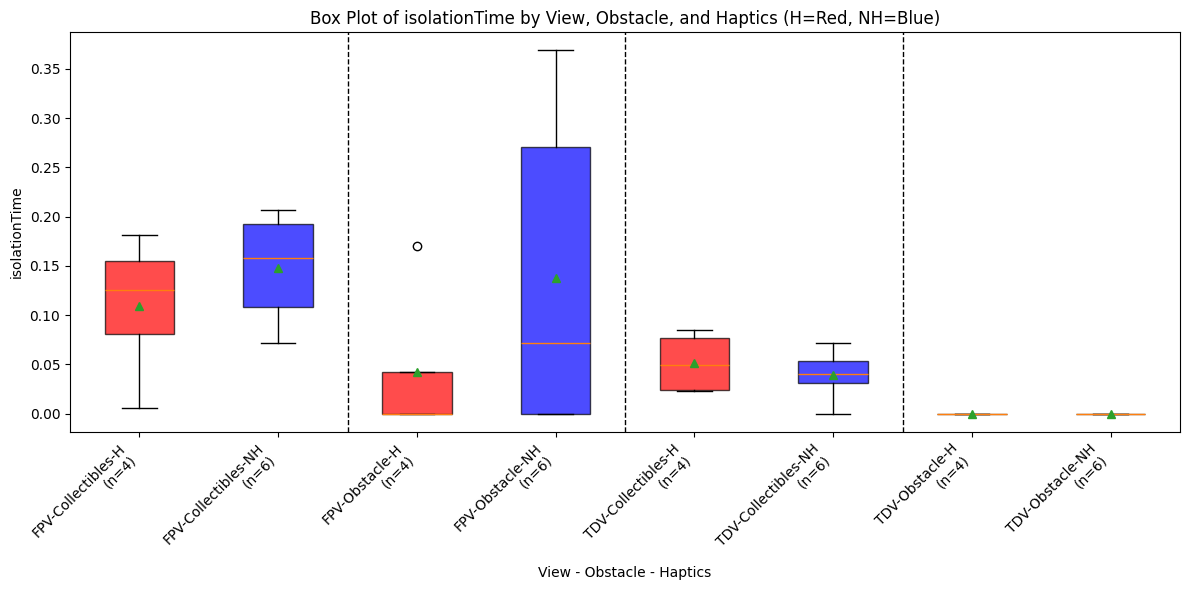

In [475]:
boxPlotSituation(dfFolders, "isolationTime")

## Speed on trajectory

[17.94480071 -4.50086528]     [ -0.98607292 115.16585498]
30


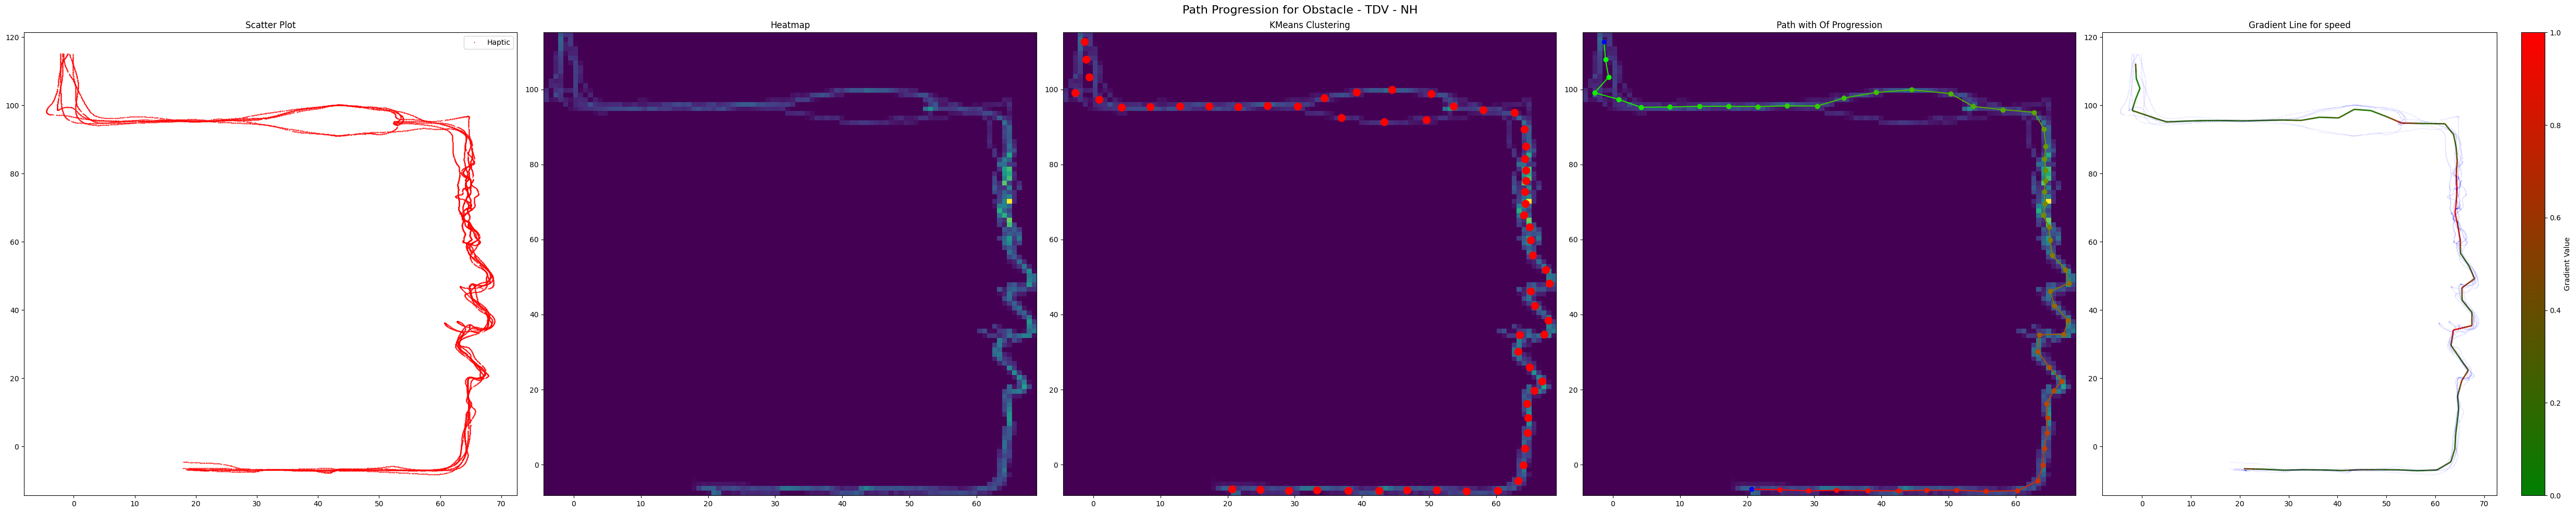

In [495]:
showPlot(1, dfConditions)

## Spread

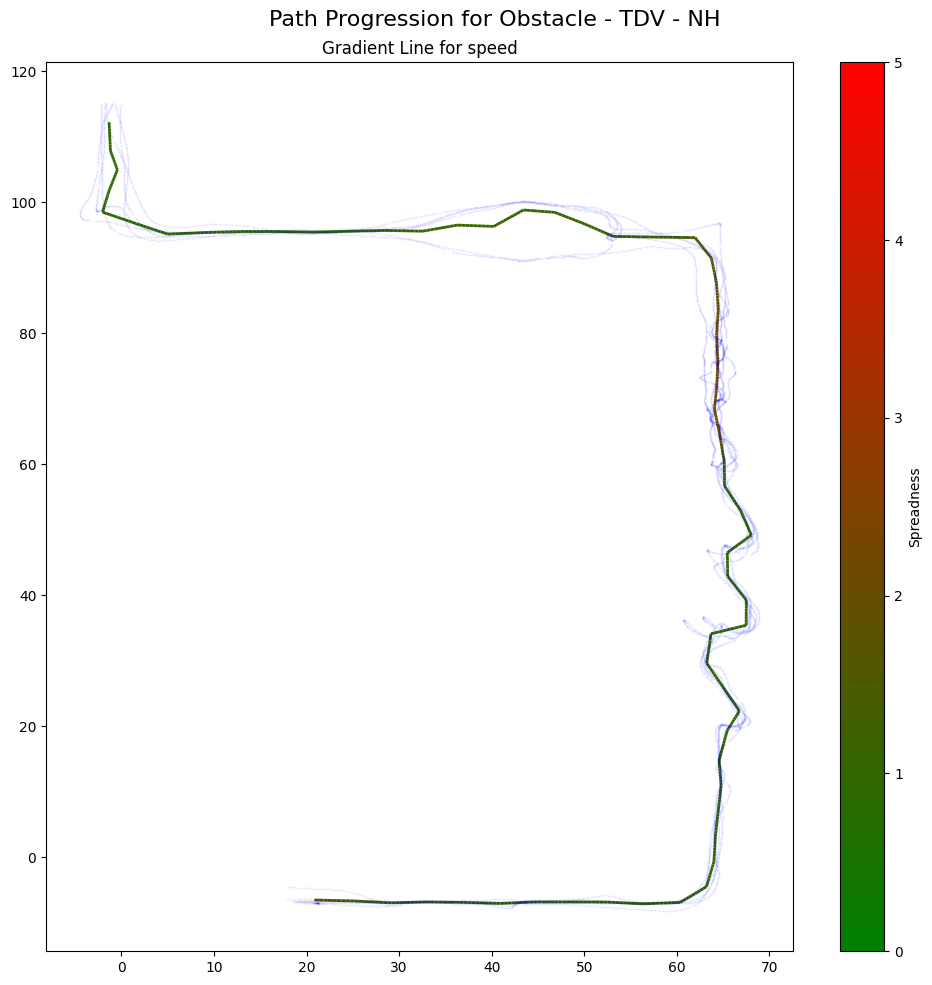

In [508]:
showPlot_spread(1, dfConditions)

## Stars

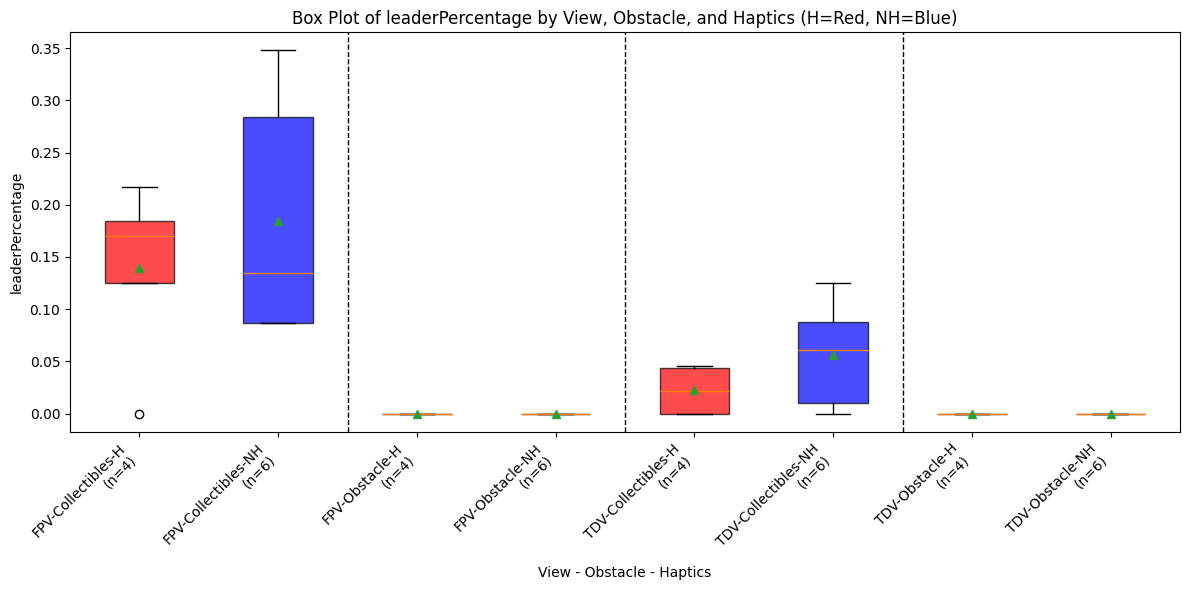

In [496]:
boxPlotSituation(dfFolders, "leaderPercentage")

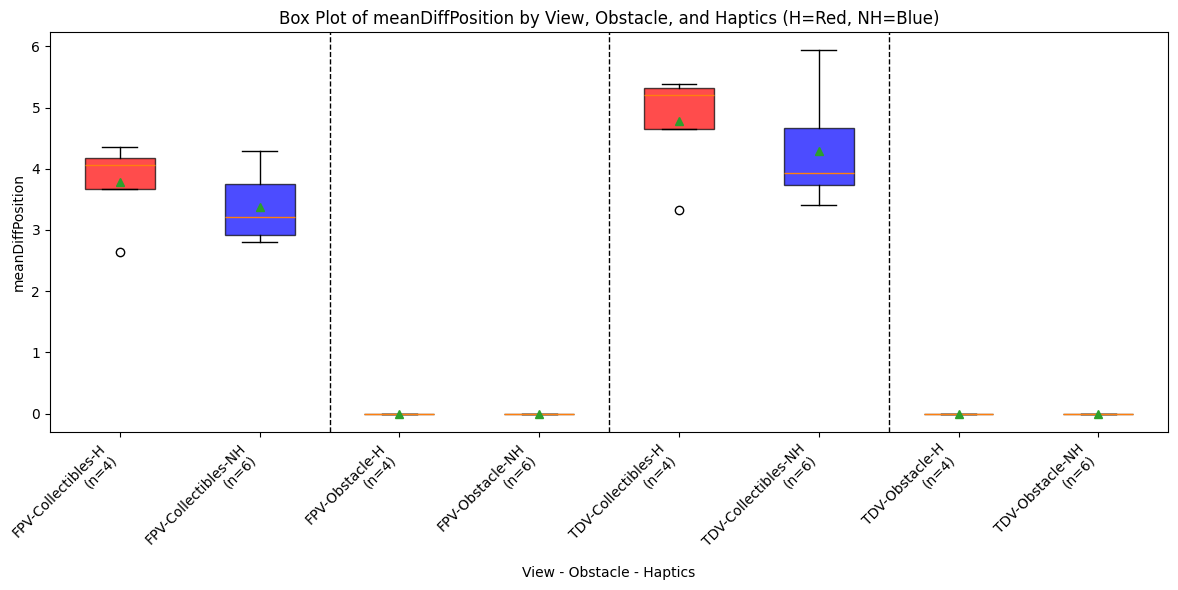

In [497]:
boxPlotSituation(dfFolders, "meanDiffPosition")